In [77]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# **How to Interact with Climate Models through Machine Learning-based Emulators**

Authors:

*   Björn Lütjens, MIT, lutjens@mit.edu
*   Lea M. Hadzic, MIT, leamum@mit.edu
*   Dava Newman, MIT, dnewman@mit.edu
*   Mark Veillette, MIT Lincoln Laboratory, mark.veillette@ll.mit.edu

Climate models are essential in policy making. Current climate models, however, are quite impractical for answering quick ‘what-if’ questions, because they are too slow. For example, 'what-if we plant one trillion trees' or 'what if we support carbon tax'. The below TEDx video goes into more detail. This tutorial will teach machine learning (ML) practicioners and scientists how to create a fast approximation of climate models. We call those approximations 'emulators'. We will introduce the problem set-up, data, and evaluation metrics to get started with climate emulation. For the ML community, creating climate emulators poses unanswered challenges in long-term time series, physical consistencies, and high-dimensional datasets.

***How Machine Learning can Empower Local Climate Voices* | Björn Lütjens | TEDxBoston**

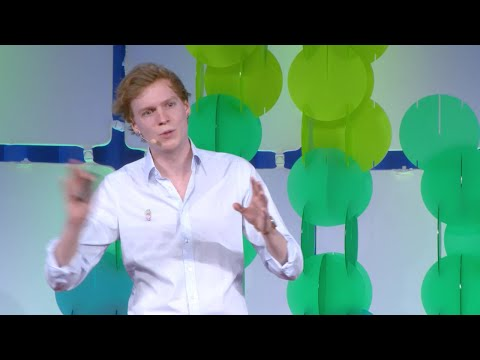

In [78]:
from IPython.display import YouTubeVideo
YouTubeVideo('DTX8SvdtrmU')

# Introduction

## Table of Contents


*   [Climate Impact](#climate-impact)
*   [Overview](#overview)
*   [Target Audience and Prerequisites](#target-audience-prereqs)
*   [Installation](#software-requirements)
*   [Downloading Climate Model Data](#data-description)
*   [Machine Learning-based Emulators](#methodology)
*   [Evaluating Emulators](#results-and-discussion)
*   [References](#references)


<a name="climate-impact"></a>
## Climate emulators empower local climate voices

Modeling the possible outcomes of anthropogenic drivers of climate change, including its impacts on society and ecosystems, is important for decision makers to define adequate and effective adaptation and mitigation measures. Since a multitude of different emission pathways compatible with the Paris agreement exist, they critically rely on climate models to be able to understand climate change and climate policies. These models, however, require inaccessible supercomputers. As a result, any task that requires multiple model runs, such as risk or sensitivity analyses, is expensive. In particular, interacting with climate models through educational ‘what-if’ scenarios, e.g. ‘what-if we plant one trillion trees,’ is too expensive (O’Neill et al., 2016). Consequently, policy makers have to mostly rely on simple approximations instead (Millar et al., 2017). They need better climate emulators to explore local climate impacts and enable more precise decisions.

The crux of the computational complexity is that the underlying differential equations have to be solved for every scenario or parameter update from scratch. Machine learning (ML) promises a paradigm shift: the idea behind ML-based ‘*emulators*’ is to train ML models on large databases of simulated data. After training, the model will have memorized how to solve the differential equations and can be quickly run again for new parameter updates.

ML-based emulators have attracted attention in the Earth sciences by predicting weather in seconds rather than hours and in machine learning due to challenges in physical structure, high-dimensionality, and long-term stability. While there exists tutorials for emulating the weather (Pathak et al., 2022), emulating the climate poses different challenges. Specifically, physical-consistency and long-term stability are fundamental in developing emulators that have to extrapolate multiple years beyond the data they have been trained on.

<a name="overview"></a>
## Overview
This tutorial will implement an interactive climate emulator that can be used to explore ‘what-if’ climate policies. Our goal is to enable Earth scientists to develop emulators for their research and ML scientists to take on the challenges in climate data. Since every Earth science emulator will require different choices, our tutorial will focus on explaining those choices, i.e. when to use non-ML vs. ML and how to incorporate physical knowledge. The final model can be used to illustrate and explore climate policies. Building on En-ROADS, this will be the first interactive and spatially-resolved climate policy emulator.

<a name="target-audience"></a>
## Target Audience, Background, and Prerequisites

This tutorial is primarily intended for data scientists that are interested in climate modeling. Specifically, we will introduce a novel time-series, video, and real-world dataset that introduces challenges in long-term stability and physical structure. The scientists are expected to have familiarity with Python, pytorch, general deep learning models, and pipeline (dataloader, loss fn). A background in climate science is not necessary. The students will walk away with a notebook on how to access and train a baseline pure and hybrid ML model on a common weather/ climate dataset.

Prerequisite references:
- Q&A: How do climate models work? [Carbon Brief](https://www.carbonbrief.org/qa-how-do-climate-models-work/)
- Deep learning basics: [I. Goodfellow, Y. Bengio, A. Courville, Deep Learning, book](https://github.com/janishar/mit-deep-learning-book-pdf)

## Other Reference:
* [ClimateLearn: Tutorial for Emulating Weather and Downscaling Climate](https://colab.research.google.com/drive/1dQ_V5-y1ieRqrpTG4po_Kx_D8NvZwRyK?usp=sharing#scrollTo=k7JdGELMXpIw)

<a name="software-requirements"></a>
## Software Requirements
All of the software required will be managed at [github.com/blutjens/climate-emulator-tutorial](https://github.com/blutjens/climate-emulator-tutorial). Running the cell below will install the required dependencies into your Colab space. The following domain specific packages are installed as part of this call:

*   `cartopy` - Geospatial plotting
*   `netcdf`- Data storage format of most climate data
*   `xarray`- Wraps around numpy to have labeled arrays. Standard for climate data.
*   `torch`- Deep learning
*   `emcli` - Emulator code used for this tutorial

In [1]:
%%capture
import os
repo_root = './' # use 'climate-emulator-tutorial/' on colab and './' on local machine

if not os.path.exists(repo_root):
    !git clone https://github.com/blutjens/climate-emulator-tutorial # fresh clone
    !pip install -r climate-emulator-tutorial/requirements.txt  # install all requirements
    !pip install climate-emulator-tutorial/                     # installs emcli
# else:
#     !git -C climate-emulator-tutorial/ pull                           # check for updates

In [2]:
# Import modules
# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# todo: mount GPU on colab.

<a name="data"></a>
# Data

<a name="data-description"></a>
## Data Description

Within our goal of emulating climate models, we have many choices to make. Here, we demonstrate how an emulator can help users explore the local temperature impact of varying climate emission scenarios.

For this task, we chose to leverage the ClimateBench dataset, which is a benchmark dataset for emulation of climate variables derived from a full complexity Earth System Model, and slightly modify it (Watson-Parris et al., 2022). This presents us with XXX data samples at XXX resolution.

## Data Download

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# drive.flush_and_unmount()

In [4]:
data_root = repo_root + 'data/'
path_climatebench_data = data_root + 'raw/climatebench/' # climatebench data

In [5]:
# Download ClimateBench into Google drive. Downloading the 914MB can take ~25min.
if not os.path.exists(path_climatebench_data):
    os.makedirs(path_climatebench_data)
if not os.path.exists(path_climatebench_data + 'train_val.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/train_val.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/train_val.tar.gz" -C $path_climatebench_data
if not os.path.exists(path_climatebench_data + 'test.tar.gz'):
    ! wget https://zenodo.org/record/7064308/files/test.tar.gz -P $path_climatebench_data
    ! tar -xvf "$path_climatebench_data/test.tar.gz" -C $path_climatebench_data

## Data Preprocessing
This section formats the raw data into a CO2 -> temp mapping.

The raw data contains annual CO2 and temperature snapshots from five climate scenario simulations. Each snapshot is a (144 x 96) pixel image (width x length; lon x lat). Three scenarios have only been run on the past (hist-GHG, hist-aer, and historical) containing data from 1850-2014 and four scenarios (ssp126, -245, -370, and -585) have been run on past and future containing 1850–2100. The scenarios are detailed in ClimateBench Table 1. We hold out two scenarios from the 'middle ranges' (historical and ssp245) to evaluate if a learned model can interpolate.

- Normalize
- Train, val, test split
- Visualize data distribution
- Describe climate data choices: CMIP6, model, scenario, variable, realization. Explain SSP.
- Describe co2, temp and alternative variable
- Load as direct mapping co2 - temp

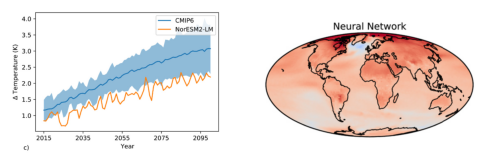

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import math

images = []
images.append(repo_root+'docs/figures/tutorial/global_t_over_time_in_ssp245.png')
images.append(repo_root+'docs/figures/tutorial/t_over_space_avg_2080_2100_ssp245.png')

plt.figure(figsize=(6,4))
columns = 2
for i, image in enumerate(images):
    plt.subplot(math.ceil(len(images) / columns), columns, i + 1)
    im = Image.open(image)
    plt.imshow(im)
    plt.axis('off')

In [7]:
#@title code: load ClimateBench training data
from emcli.dataset.climatebench import load_climatebench_data

scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer']
len_historical = 165
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=len_historical, 
  data_path=data_path)

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [8]:
#@title code: Normalize training data
# note: climatebench does not normalize outputs, Y_train.
from emcli.dataset.climatebench import compute_mean_std_X_train
from emcli.dataset.climatebench import normalize_data_arr

# Compute mean and standard deviations of each input variable
meanstd_inputs = {}
for var in ['CO2', 'CH4', 'SO2', 'BC']:
    meanstd_inputs[var] = compute_mean_std_X_train(data_arr = X_train, var=var)
# Normalize the input data array.
X_train_norm = normalize_data_arr(data_arr=X_train, meanstd=meanstd_inputs, keys=['CO2', 'CH4', 'SO2', 'BC'])

In [10]:
#@title code: Load test data

scenarios_test = ['ssp245']

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)

# opt: Drop non-relevant variables
# X_test = [X.drop(['SO2','CH4','BC']) for X in X_test]
# Y_test = [Y.drop(['diurnal_temperature_range','pr','pr90']) for Y in Y_test]

# Normalize test data
X_test_norm = normalize_data_arr(data_arr=X_test, meanstd=meanstd_inputs)#, keys=['CO2', 'CH4', 'SO2', 'BC'])
# todo: verify Y_test normalization in https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp245


In [57]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios:\n\t', len(X_train))
print('Training set, shape of CO2 input and tas output for historical scenario:\n\t', X_train[3]['CO2'].shape, Y_train[3]['tas'].shape)
print('Test set, number of scenarios:\n\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\n\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)
print('Mean and standard deviations:')
[print('\t' + key + ' train mean, std: \t', meanstd_inputs[key]) for key in meanstd_inputs];

Input Data variables:
    CO2      (time) float64 0.1883 0.3772 0.5738 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 0.03131 0.03174 0.03218 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.03264 .....
    tas                        (time, latitude, longitude) float32 0.32 ... 3...
    pr                         (time, latitude, longitude) float64 0.02337 .....
    pr90                       (time, latitude, longitude) float64 0.02468 .....
Training set, number of scenarios:
	 5
Training set, shape of CO2 input and tas output for historical scenario:
	 (165,) (165, 96, 144)
Test set, number of scenarios:
	 1
Test set, shape of CO2 input and tas output:
	 (251,) (251, 96, 144)
Mean and standard deviations:
	CO2 train mean, std: 	 (1074.172303244536, 1755.6906992

## Data Visualization:
- todo :
  - Visualize inputs: globally averaged CO2 concentration over time of all scenarios: X_train[i]['CO2'] for i in range(n_scenarios)
  - Visualize outputs: global field of surface temperature of the latest year ( i think 2014?) and scenario: X_train[i]['tas'][-1]
    - todo: how to viz time and scenarios. Maybe omit?
  - Basic data statistics:
    - [x] shape of train/test data
    - number of train/test data points: sum(X_train[i]['CO2].shape[0] for i in range(n_scenarios))
  - (Opt) advanced data statistics:
    - average autocorrelation in between each time step.

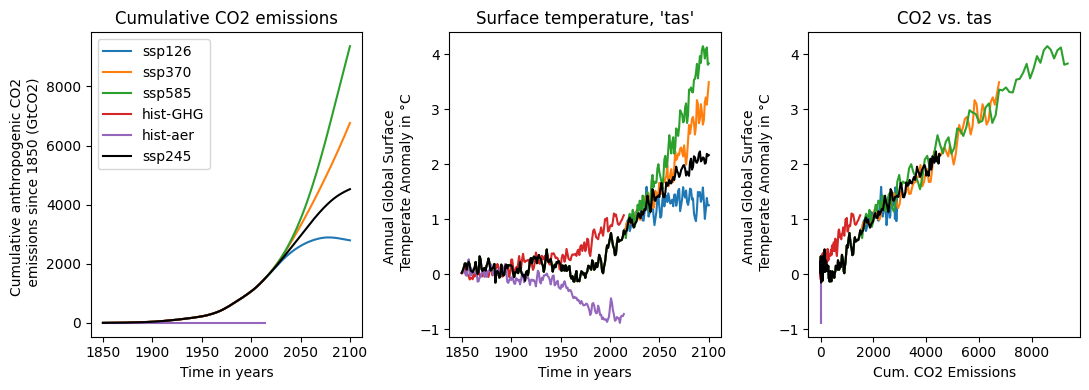

In [72]:
%reload_ext autoreload
%aimport emcli

import emcli.utils.plotting as plotting
plotting.plot_co2_tas_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test);

### All globally-averaged data variables

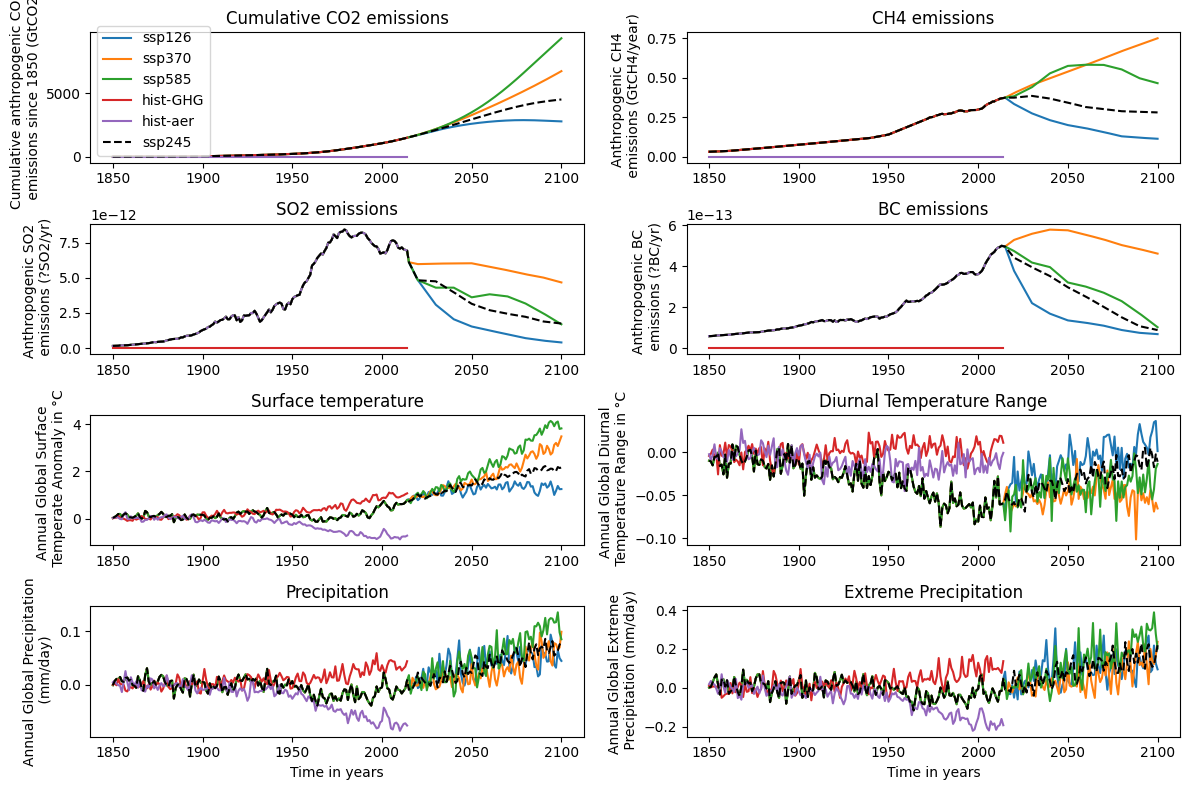

In [34]:
import emcli.utils.plotting as plotting

axs = plotting.plot_all_vars_global_avg(X_train=X_train, 
            X_test=X_test, 
            Y_train=Y_train, 
            Y_test=Y_test,
            scenarios_train=scenarios_train,
            scenarios_test=scenarios_test)

<a name="methodology"></a>
# Methodology

Currently, some of the best models for achieving our goal are Convolutional Neural Networks (CNN) and Random Forests (RF). These emulators can predict annual mean global distributions of temperature and precipitation given the wide range of emissions and concentrations of carbon dioxide, methane, and aerosols (Watson-Parris et al., 2022). While neural networks scale well, they build representations from spatially close regions of the input, leading to a spatial locality bias (Cachay et al., 2021). Many climate phenomena, though, are driven by global interactions. In contrast, random forests are interpretable, but don’t scale well. The goal is to outperform these models by being both  faster and more precise. Thus, in this tutorial, we will specifically look at ClimateBench’s RF and CNN models as baselines to compare our results.

- **Time-instant mapping** predicts a global surface temperature field at a given year from a global-average CO2 concentration in the same year. This resembles a boundary condition problem.
-	**Autoregressive model** incrementally predicts the global surface temperature field of a year from the global-average CO2 concentration at that year and a global surface temperatue field of the previous year. This resembles an initial condition model.
- Limitations:
 - Does not contain seasonality. Possibly extend to feed (sin,cos) of year as input.
 - Averages over variation of other featues (CH4, SO2, BC)

## Time-instant map: GHGs(t) -> temperature(t):

- Prediction task:
  - $f_{global}: co2_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{global-mean}(t) \in \mathbb{R}$
  - $f_{local}: tas_{global-mean}(t) \in \mathbb{R} \rightarrow tas_{0:lat, 0:lon}(t) \in \mathbb{R}^{(lat, lon)}$
- Models:
  - Linear: 
    - $f_{global}$ is linear regression,
    - $f_{local}$ is pattern scaling, i.e., one linear regression model per grid cell
  - Fully-connected Neural Net (FCNN):
    - $f_{global}$: [batch_size,1,1,1] —> (dense layers) -> [batch_size,1,1,1]
    - $f_{local}$: [batch_size,1,1,1] -> (dense layers) -> [batch_size,1,1,lat*lon] —> Reshape(batch_size,1,lat,lon)
  - UNet:
    - [batch_size, 1, 1, 96 * 144] —> Reshape(batch_size, 1, 96, 144) -> UNet -> (batch_size, 1, 96, 144) -> tanh?()
- Issue:
  - No memory. Instant quadrupling of CO2 will result in instant temperature quadrupling.

### Linear time-instant: global GHG -> global tas

In [74]:
#@title: fit linear model for global GHGs -> global tas

import emcli.models.pattern_scaling.model as ps
import emcli.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train,#[:-1], # could leave out hist-aer for training, but didn't really matter
                             Y_global_local=Y_train,# [:-1],
                             input_keys=['CO2'],
                             target_keys=['tas'],
                             save_dir=dir_global_global+'train/')

# Fit Linear regression model from global ghg at t -> global tas as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = 'global_co2_to_global_tas.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=['tas'],
                             save_dir=dir_global_global+'test/')

# Load model
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ./data/interim/global_global/train/
Saving processed data at:  ./data/interim/global_global/test/


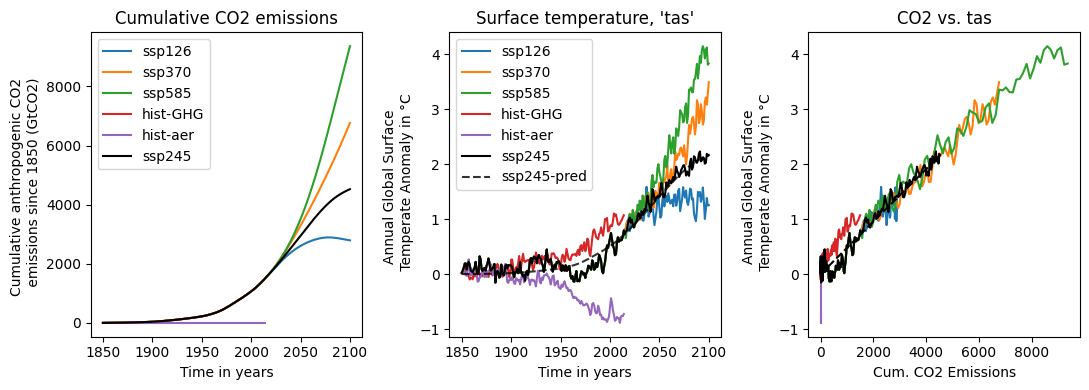

In [77]:
# Plot linear regression predictions

import emcli.utils.plotting as plotting
plotting.plot_co2_tas_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr);

#### Pattern scaling: global tas -> local tas

In [78]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli
import importlib
importlib.reload(emcli)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli.models.pattern_scaling.model as ps

# Retrieve global temperatures for training
tas_global = target_train.flatten() # (n_time,)
# Retrieve annual local temperature field for training
tas_local = np.concatenate([dataset['tas'].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(tas_global, tas_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = 'global_tas_to_local_tas.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Retrieve test data. Use global tas predictions from previous model as input
tas_global_test = preds_lr.flatten() # (n_time,)
# tas_global_test = target_test.flatten() # (n_time,) # use ground-truth global tas as input

# Load model
# pattern_scaling = ps.load(dir=dir_pattern_scaling)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(tas_global_test) # (n_time, n_lat, n_lon)

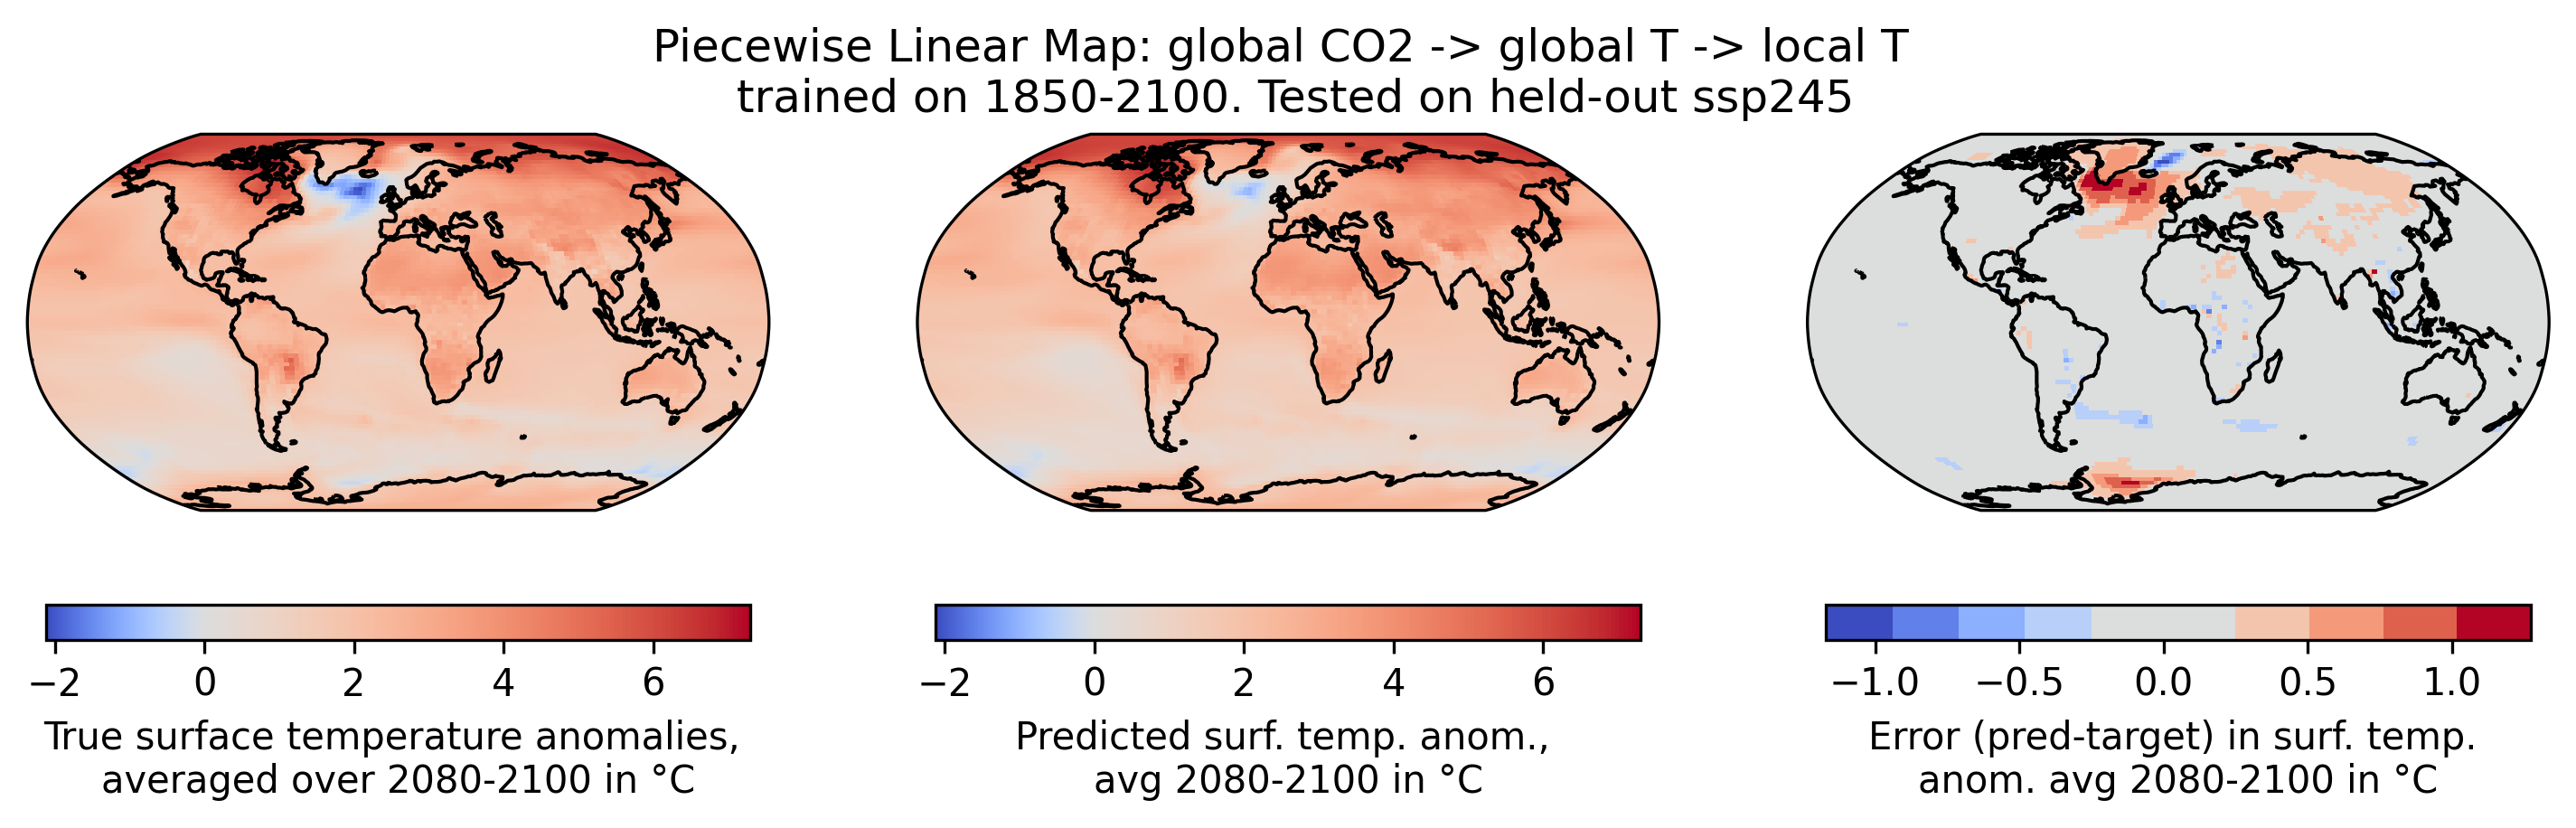

In [93]:
# Plot error map
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0]['tas'].coords) # convert predictions into axarray
axs = plot_tas_annual_local_err_map(Y_test[0]['tas'], preds_pattern_scaling_xr)
axs[1].set_title(f'Piecewise Linear Map: global CO2 -> global T -> local T \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

## Autoregressive Markovian forecasting of temperature:

- Prediction task:

$[\text{co2}_\text{global-mean}(t), \text{tas}_{0:Lat, 0:Lon}(t)] \in \mathbb{R}^{3}\times \mathbb{R}^{(Lat,Lon)} \rightarrow \text{tas}_{0:Lat, 0:Lon}(t+1) \in \mathbb{R}^{(Lat, Lon)}$

- Limitations
  - Captures atmospheric heating due to co2. Assumes that the state (tas and co2) captures the full carbon cycle. But it doesn't capture longer term effects like ocean heating, ice loss, etc.
  - Spikes in CO2 would not be accurately modeled.

In [17]:
#@title code: Create train and test dataset

from emcli.dataset.autoregressiveDataset import AutoregressiveDataset

len_snippet = 1 # Number of time steps that target is ahead of input.
# E.g., [t=0]->[t=3] for len_snippet = 3. This is also the number of
# autoregressive model forecasting steps until the loss is applied.
ar_dataset_train = AutoregressiveDataset(X_train, Y_train,
    len_snippet=len_snippet, split='train')
ar_dataset_test = AutoregressiveDataset(X_test, Y_test,
    len_snippet=len_snippet, split='test')

input_sample, output_sample = ar_dataset_train.__getitem__(idx=0)
print('Number of training data samples: ',len(ar_dataset_train))
print('Number of test data samples: ',len(ar_dataset_test))
print('Input sample: ', input_sample.shape, input_sample.dtype)
print('Output sample: ', output_sample.shape, output_sample.dtype)

Number of training data samples:  1078
Number of test data samples:  250
Input sample:  torch.Size([1, 2, 96, 144]) torch.float32
Output sample:  torch.Size([1, 96, 144]) torch.float32


In [18]:
# Create data loaders
# We use the test as val set due to our limited data size. This seems acceptable
# as we will perform limited amount of hyperparameter tuning.
from torch.utils.data import DataLoader

batch_size = 8
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
ar_train_loader = DataLoader(ar_dataset_train, shuffle=True, **loader_args)
ar_val_loader = DataLoader(ar_dataset_test, shuffle=False, drop_last=True, **loader_args)

In [19]:
#@title code: PushforwardUNet
from emcli.models.unet.unet_model import PushforwardUNet

In [20]:
#@title code: evaluate.py -> evaluate()

import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

@torch.inference_mode()
def evaluate(model, dataloader, criterion, device, amp):
  model.eval()
  n_val = len(dataloader.dataset)
  num_val_batches = len(dataloader)
  total_loss = 0

  # iterate over the validation set
  # with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
  with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    with tqdm(total=n_val, desc='validation.', unit='img', leave=False) as pbar2:
      for i, (inputs, targets) in enumerate(dataloader):
        batch_size = inputs.shape[0]
        inputs = inputs.to(device=device)# , memory_format=torch.channels_last)
        targets = targets.to(device=device)# , memory_format=torch.channels_last)

        pred = model(inputs)

        total_loss += criterion(pred, targets)

        pbar2.update(batch_size)
        pbar2.set_postfix(**{'val MSE/img': total_loss.cpu().numpy() / float(i+1)})

  model.train()
  return total_loss / max(num_val_batches, 1)

# val_score = evaluate(model, ar_val_loader, nn.MSELoss(), device, cfg["amp"])

In [21]:
#@title code: train.py -> train_model()

from torch import optim
from tqdm.notebook import tqdm
from pathlib import Path

def train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
        no_wandb: bool = False,
        parallel: bool = False,
        dir_checkpoint: str = '',
        cfg: dict = None,
  ):
  """
  Train model
  Source: https://github.com/milesial/Pytorch-UNet/blob/2f62e6b1c8e98022a6418d31a76f6abd800e5ae7/train.py#L81
  """
  # (Initialize logging)
  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  if not no_wandb:
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(dict(epochs=epochs, batch_size=batch_size,
        learning_rate=learning_rate, val_percent=val_percent,
        save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp))

  logging.info(f'''Starting training:
      Epochs:          {epochs}
      Batch size:      {batch_size}
      Learning rate:   {learning_rate}
      Training size:   {n_train}
      Validation size: {n_val}
      Checkpoints:     {save_checkpoint}
      Device:          {device.type}
      Images scaling:  {img_scale}
      Mixed Precision: {amp}
  ''')

  # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
  optimizer = optim.RMSprop(model.parameters(),
                lr=learning_rate, weight_decay=weight_decay,
                momentum=momentum, foreach=True)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 'min', patience=5)  # goal: minimize MSE
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.MSELoss()
  global_step = 0

  print('batch_size')
  # Begin training
  for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
      for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device=device)# , memory_format=torch.channels_last)
        targets = targets.to(device=device)# , memory_format=torch.channels_last)

        assert inputs.shape[2] == model.n_channels, \
          f'Network has been defined with {model.n_channels} input channels, ' \
          f'but loaded images have {inputs.shape[2]} channels. Please check that ' \
          'the images are loaded correctly.'

        with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
          pred = model(inputs)
          # todo: check if loss calculates batch correctly
          loss = criterion(pred, targets)

        # todo: double check if gradients only go back to last network
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()

        pbar.update(inputs.shape[0])
        global_step += 1
        epoch_loss += loss.item()
        if not no_wandb:
          experiment.log({
              'train loss': loss.item(),
              'step': global_step,
              'epoch': epoch
          })
        pbar.set_postfix(**{'avg MSE/img': epoch_loss / float(i+1)})

        # Evaluation round
        division_step = (n_train // (1 * batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in model.named_parameters():
              if not no_wandb:
                tag = tag.replace('/', '.')
                if not (torch.isinf(value) | torch.isnan(value)).any():
                  histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                  histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            val_score = evaluate(model, val_loader, criterion, device, amp)
            scheduler.step(val_score)

            logging.info('Validation Dice score: {}'.format(val_score))
            try:
              experiment.log({
                'learning rate': optimizer.param_groups[0]['lr'],
                'validation Dice': val_score,
                'inputs': wandb.Image(inputs[0].cpu()),
                'predictions': {
                  'true': wandb.Image(targets[0].float().cpu()),
                  'pred': wandb.Image(pred.argmax(dim=1)[0].float().cpu()),
                },
                'step': global_step,
                'epoch': epoch,
                **histograms
              })
            except:
              pass

    if save_checkpoint:
      Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
      state_dict = model.state_dict()
      torch.save(state_dict, str(Path(dir_checkpoint) / 'checkpoint_epoch{}.pth'.format(epoch)))
      logging.info(f'Checkpoint {epoch} saved!')

In [22]:
train_model(
  model=model,
  train_loader=ar_train_loader,
  val_loader=ar_val_loader,
  epochs=cfg["epochs"],
  batch_size=cfg["batch_size"],
  learning_rate=cfg["learning_rate"],
  device=device,
  img_scale=cfg["scale"],
  val_percent=cfg["validation"] / 100.,
  amp=cfg["amp"],
  no_wandb=cfg["no_wandb"],
  dir_checkpoint=cfg["dir_checkpoint"],
  cfg=cfg,
)

NameError: name 'model' is not defined

cuda


<a name="results-and-discussion"></a>
# Results & Discussion

-	Metrics:
  -	(area weighted) RMSE – blurry, no scale
  - Bias? – measure biases over whole domain (used in precip.)
  - Bias over x-y location
- Temporal forecasting
  -	ACC over forecast time – kind of normalized rmse
-	Baseline models:
  -	Climatology
  -	Linear response surface
  - Compare results with CNN and RF

In [ ]:
# Insert code here. Feel free to break this up into several code
# cells, interleaved with explanatory text.

## Limitations:
Models:
- The autoregressive and time-instant model does not model time history. As a result, multi-year patterns, such as ENSO, and seasonal patterns (Winter, Spring, Summer, etc.) are not captured. The seasonal patterns could be captured by taking month as input:
- Monthly time-instant mapping:
  - $[co2_{global-mean}(t), \sin(t_\text{month}), \cos(t_\text{month})] \in \mathbb{R}^3 \rightarrow tas_{0:Lat, 0:Lon}(t) \in \mathbb{R}^{(Lat, Lon)}$
  - $t_\text{month} = \{0°,30°,60°,...330°\}$ for $\{\text{Jan., Feb., ..., Dec.}\}$


Others:

Emulation of the future climate poses particular challenges for machine learning due to the limited amount of training data. Current ML approaches struggle to learn such complex scenarios in small data regimes. As noted earlier, the complex models that are used for modeling are computationally expensive, and there is no information about unseen future scenarios. Furthermore, to build trust in climate emulators for policymakers, model verification is attempted to assert its accuracy objectively. However, this is formally impossible for the Earth, so model evaluation must be completed and relies on underlying physical principles to reassure its broader validity.


In this tutorial, we use a pure ML approach instead of a hybrid physics machine learning. Hybrid physics ML presents a few broader challenges. Most notably, it is challenging to bring together and integrate i.e. statistics, uncertainty quantification, physics, etc. There is also a challenge of balancing the competing demands of hard and soft constraints to develop a model that accurately captures the physics while also being flexible enough to capture the complexities of the problem. This requires careful consideration of the underlying physics and expertise in ML techniques and optimization methods.

Lastly, when it comes to uncertainty quantification, estimating the model (epistemic) and data (aleatoric) uncertainty in and with ML models, respectively, is still an open research field. However, addressing these challenges is crucial to improving the usefulness, reliability, and trust of ML emulators, particularly in an application like this where accurate climate risks, such as likelihood of freezing days in March, number of heat days, distribution over storm surge heights, etc., are critical for decision-makers to enact adequate climate adaptation and mitigation measures.

## Next Steps:
This tutorial only gives a short insight into machine learning in climate science. There exist many outstanding challenges and we refer to some here:

- Other models:
  - end-to-end emulator: init temp + global co2 over time -> temp at 2030
- Other metrics:
  -	Extremes:
    - plot probability distribution of temp.
  -	Response surfaces:
    -	global co2 -> global temp., co2 -> boston temp., co2 -> beijing temp, etc.
-	Common Issues:
 -	Dataset size, CPU vs. GPU
-	Open Challenges:
 -	Extreme measurement
 -	Extend to more data via cesm-emulator notebook

*   What do you imagine would be the next steps for your readers after finishing your tutorial?
*   Discuss other potential climate-related applications for the method or tool discussed in the tutorial.
*   Do you know of other climate-related datasets similar to the one used in this tutorial? List them here.

### todos:
- add video of tutorial presentation.

<a name="references"></a>
# References

Please cite this abstract if you consider this tutorial useful:
```
Lütjens, Björn, Lea M. Hadzic, Dava Newman, and Mark Veillette. "The Climate Pocket: Tutorial on Building Fast Emulators in Climate Modeling." AGU23 (2023). online: https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1304372
```

Other References

*   Cachay, R. et al. (2021). The World as a Graph: Improving El Niño Forecasts with Graph Neural Networks. https://doi.org/10.48550/arXiv.2104.05089.


*   Millar, R. et al. (2017). Emission budgets and pathways consistent with limiting warming to 1.5 °C. Nature Geoscience, 10, 741–747, https://doi.org/10.1038/ngeo3031.


*   O'Neill, B. C. et al. (2022). The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geosci. Model Dev., 9, 3461–3482, https://doi.org/10.5194/gmd-9-3461-2016.


*   Pathak et al. (2022). FourCastNet: A Global Data-Driven High-Resolution Weather Model Using Adaptive Fourier Neural Operators. https://doi.org/10.48550/arXiv.2202.11214.


*   Watson-Parris, D. et al. (2022). ClimateBench v1.0: A Benchmark for Data-Driven Climate Projections. Journal of Advances in Modeling Systems, 14(10), https://doi.org/10.1029/2021MS002954.

